In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Embedding, LSTM, Input, Activation, Permute, Dropout, add, dot, concatenate
from keras.utils import to_categorical
from pickle import dump, load
from nltk.corpus import words
import nltk
import spacy
import keras

import numpy as np
import random
import re

random.seed(42)

In [76]:
nlp = spacy.load('en_core_web_sm')

## Load Dataset

In [77]:
with open('Datasets/tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_test.txt', 'rb') as f:
    text_test = f.read().decode('utf-8')

with open('Datasets/tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_train.txt', 'rb') as f:
    text_train = f.read().decode('utf-8')

In [78]:
text_test

'1 Mary got the milk there.\n2 John moved to the bedroom.\n3 Is John in the kitchen? \tno\t2\n4 Mary discarded the milk.\n5 John went to the garden.\n6 Is John in the kitchen? \tno\t5\n7 Daniel moved to the bedroom.\n8 Daniel went to the garden.\n9 Is John in the garden? \tyes\t5\n10 Daniel travelled to the bathroom.\n11 Sandra travelled to the bedroom.\n12 Is Daniel in the bathroom? \tyes\t10\n13 Mary took the football there.\n14 Sandra grabbed the milk there.\n15 Is Daniel in the bedroom? \tno\t10\n1 Daniel went back to the kitchen.\n2 Mary grabbed the apple there.\n3 Is Daniel in the office? \tno\t1\n4 Daniel journeyed to the office.\n5 John went back to the office.\n6 Is Daniel in the hallway? \tno\t4\n7 Mary left the apple.\n8 Daniel went to the hallway.\n9 Is Daniel in the hallway? \tyes\t8\n10 John went to the hallway.\n11 Daniel picked up the milk there.\n12 Is John in the kitchen? \tno\t10\n13 John grabbed the football there.\n14 Mary got the apple there.\n15 Is Daniel in the 

In [79]:
text_train

'1 Mary moved to the bathroom.\n2 Sandra journeyed to the bedroom.\n3 Is Sandra in the hallway? \tno\t2\n4 Mary went back to the bedroom.\n5 Daniel went back to the hallway.\n6 Is Daniel in the bathroom? \tno\t5\n7 Sandra went to the kitchen.\n8 Daniel went back to the bathroom.\n9 Is Daniel in the office? \tno\t8\n10 Daniel picked up the football there.\n11 Daniel went to the bedroom.\n12 Is Daniel in the bedroom? \tyes\t11\n13 John travelled to the office.\n14 Sandra went to the garden.\n15 Is Daniel in the bedroom? \tyes\t11\n1 Sandra got the football there.\n2 Mary went to the bedroom.\n3 Is Mary in the bedroom? \tyes\t2\n4 Daniel got the apple there.\n5 Sandra travelled to the hallway.\n6 Is Sandra in the office? \tno\t5\n7 Sandra moved to the garden.\n8 Mary travelled to the kitchen.\n9 Is Sandra in the bathroom? \tno\t7\n10 Sandra went back to the bedroom.\n11 Daniel put down the apple.\n12 Is Sandra in the bathroom? \tno\t10\n13 Sandra put down the football.\n14 Sandra journeye

## Data Preprocessing

In [80]:
def preprocessing_data(txt):
    data = []
    record = []
    temp = None
    start = True
    for sentence in txt.split('\n'):
        doc = nlp(sentence)
        token = [i.text for i in doc]
        if len(token) == 0:
            break
        if start:
            if token[0] == '1':
                temp = []
            if temp:
                record.append(temp)
                record[0].extend(token[1:])
                temp = []
            else:
                record.append(token[1:])
            start = False
        elif '?' in token:
            record.append(token[1:-4])
            record.append(token[-3])
            temp = record[0].copy()
            data.append(record.copy())
            record = []
            start = True
        else:
            record[0].extend(token[1:])
    return data

In [81]:
train_data = preprocessing_data(text_train)
train_data

[[['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
  'no'],
 [['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.'],
  ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'],
  'no'],
 [['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'went',
   'to',
   'the',
   'kitchen',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'bathroom',
   '.'],
  ['Is', 'Daniel', 'in', 'the', '

In [82]:
test_data = preprocessing_data(text_test)
test_data

[[['Mary',
   'got',
   'the',
   'milk',
   'there',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'John', 'in', 'the', 'kitchen', '?'],
  'no'],
 [['Mary',
   'got',
   'the',
   'milk',
   'there',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'discarded',
   'the',
   'milk',
   '.',
   'John',
   'went',
   'to',
   'the',
   'garden',
   '.'],
  ['Is', 'John', 'in', 'the', 'kitchen', '?'],
  'no'],
 [['Mary',
   'got',
   'the',
   'milk',
   'there',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'discarded',
   'the',
   'milk',
   '.',
   'John',
   'went',
   'to',
   'the',
   'garden',
   '.',
   'Daniel',
   'moved',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'to',
   'the',
   'garden',
   '.'],
  ['Is', 'John', 'in', 'the', 'garden', '?'],
  'yes'],
 [['Mary',
   'got',
   'the',
   'milk',
   'there',
   '.',
   'John',
   'moved',


## Create a Vocabulary to Store all Words

In [83]:
vocab = set()

In [84]:
merged_data = train_data + test_data

In [85]:
for story, question, _ in merged_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [86]:
vocab.add('yes')
vocab.add('no')
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [87]:
VOCAB_LEN = len(vocab) + 1
VOCAB_LEN

38

In [88]:
MAX_STORY_LEN = max(len(data[0]) for data in merged_data)
MAX_STORY_LEN

156

In [89]:
MAX_QUESTION_LEN = max(len(data[1]) for data in merged_data)
MAX_QUESTION_LEN

6

## Vectorize the Data

In [90]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [91]:
tokenizer.word_index

{'up': 1,
 'yes': 2,
 'bedroom': 3,
 'dropped': 4,
 'daniel': 5,
 'football': 6,
 'no': 7,
 'john': 8,
 'got': 9,
 'went': 10,
 'garden': 11,
 'down': 12,
 'is': 13,
 'there': 14,
 'back': 15,
 'kitchen': 16,
 'moved': 17,
 'left': 18,
 'discarded': 19,
 'sandra': 20,
 'apple': 21,
 'to': 22,
 '?': 23,
 'in': 24,
 '.': 25,
 'picked': 26,
 'grabbed': 27,
 'put': 28,
 'the': 29,
 'travelled': 30,
 'office': 31,
 'bathroom': 32,
 'journeyed': 33,
 'hallway': 34,
 'took': 35,
 'milk': 36,
 'mary': 37}

In [120]:
tokenizer.word_index['yes']

2

In [121]:
tokenizer.word_index['no']

7

In [92]:
# train_story_text = []
# train_question_text = []
# train_answers = []

# for story,question,answer in train_data:
#     train_story_text.append(story)
#     train_question_text.append(question)

# len(train_story_text)

In [93]:
# train_story_seq = tokenizer.texts_to_sequences(train_story_text)
# len(train_story_seq)

In [94]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=MAX_STORY_LEN, max_question_len=MAX_QUESTION_LEN):
    story_vectors = []
    question_vectors = []
    answer_indices = []  # Use indices instead of one-hot vectors

    for story, question, answer in data:
        # Vectorize the story and question
        story_vectors.append(
            [word_index.get(word.lower(), 0) for word in story[-max_story_len:]]
        )
        question_vectors.append(
            [word_index.get(word.lower(), 0) for word in question[-max_question_len:]]
        )
        
        # Store the answer as an index
        answer_indices.append(word_index.get(answer.lower(), 0))

    # Pad all sequences at once
    story_vectors = pad_sequences(story_vectors, maxlen=max_story_len)
    question_vectors = pad_sequences(question_vectors, maxlen=max_question_len)
    answer_indices = np.array(answer_indices)

    return story_vectors, question_vectors, answer_indices


In [95]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [96]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [97]:
inputs_train

array([[ 0,  0,  0, ..., 29,  3, 25],
       [ 0,  0,  0, ..., 29, 34, 25],
       [ 0,  0,  0, ..., 29, 32, 25],
       ...,
       [ 0,  0,  0, ..., 29,  3, 25],
       [ 0,  0,  0, ..., 36, 14, 25],
       [ 0,  0,  0, ..., 21, 14, 25]], dtype=int32)

In [98]:
inputs_test

array([[ 0,  0,  0, ..., 29,  3, 25],
       [ 0,  0,  0, ..., 29, 11, 25],
       [ 0,  0,  0, ..., 29, 11, 25],
       ...,
       [ 0,  0,  0, ..., 29, 21, 25],
       [ 0,  0,  0, ..., 29, 11, 25],
       [ 0,  0,  0, ..., 21, 14, 25]], dtype=int32)

In [99]:
answers_train = to_categorical(answers_train, num_classes=(len(tokenizer.word_index) + 1))
print(answers_train.shape)
answers_train

(10000, 38)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [100]:
answers_test = to_categorical(answers_test, num_classes=VOCAB_LEN)
print(answers_test.shape)
answers_test

(1000, 38)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

## Create End-to-End Memory Network (MemN2N) Model

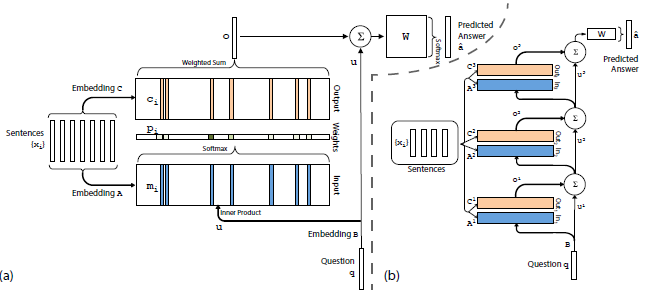

### Input Placeholders for the Stories and Questions

In [101]:
input_sequence = Input((MAX_STORY_LEN, ))
question = Input((MAX_QUESTION_LEN, ))

### Encoders

In [102]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=VOCAB_LEN,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [103]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=VOCAB_LEN,output_dim=MAX_QUESTION_LEN))
input_encoder_c.add(Dropout(0.3))

In [104]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=VOCAB_LEN, output_dim=64, input_length=MAX_QUESTION_LEN))
question_encoder.add(Dropout(0.3))

c:\Users\jayaw\.virtualenvs\Chatbot-Yes-No-Question-lJ-2E43I\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Encode the Sequences

In [105]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [106]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [107]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [108]:
answer = concatenate([response, question_encoded])
answer = LSTM(32)(answer)  # (samples, 32)
answer = Dropout(0.5)(answer)
answer = Dense(VOCAB_LEN)(answer)  # (samples, vocab_size)
answer = Activation('softmax')(answer)

In [109]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 156, 64)   │      2,432 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 6, 64)     │      2,432 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 156, 6)    │          0 │ sequential_3[0][… │
│                     │                   │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 156, 6)    │          0 │ dot_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 156, 6)    │        228 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 156, 6)    │          0 │ activation_2[0][… │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 6, 156)    │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6, 220)    │          0 │ permute_1[0][0],  │
│ (Concatenate)       │                   │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     32,384 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 38)        │      1,254 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38)        │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [36]:
# history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

## Load Model

In [111]:
model.load_weights('Models/memn2n_150_epochs.h5')

In [112]:
predictions = model.predict(([inputs_test, queries_test]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


## Check the Output of a Sample in Testing Data

In [115]:
print(' '.join(test_data[0][0]))

Mary got the milk there . John moved to the bedroom .


In [116]:
print(' '.join(test_data[0][1]))

Is John in the kitchen ?


In [118]:
print("Answer (True):", test_data[0][2])

Answer (True): no


In [119]:
for key, val in tokenizer.word_index.items():
    if val == np.argmax(predictions[0]):
        k = key

print("Predicted answer is:", k)
print("Probability of certainty:", predictions[0][np.argmax(predictions[0])])

Predicted answer is: football
Probability of certainty: 0.88964766


## Testing the Model using Own Data (Story and Question)

In [123]:
vocab # We can only use words in this vocabulary

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
own_story = 